In [1]:
from google.colab import drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Librerias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno
import statsmodels.api as sm

from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

In [4]:
#Lectura de los archivos 
data_pub= pd.read_csv('/content/drive/MyDrive/Reto_data/Publications.csv')
data_aut= pd.read_csv('/content/drive/MyDrive/Reto_data/Authors_Metrics.csv')

#Preparación de Scopus Author 
data_pub['Scopus Author Ids'] = data_pub['Scopus Author Ids'].astype(str)
data_aut['Scopus author ID'] = data_aut['Scopus author ID'].astype(str)

<ipython-input-4-2b218b315aa2>:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data_pub= pd.read_csv('/content/drive/MyDrive/Reto_data/Publications.csv')


In [5]:
#Cambiar nombre de la columna para que coincida en ambos dataframes
data_pub = data_pub.rename(columns={'Scopus Author Ids':'Scopus author ID'})

In [6]:
#Dimensiones del dataframe de publicaciones
data_pub.shape

(84366, 50)

In [7]:
#Separa a todos los autores y los añade en nuevas columnas 
Scopus_author=[]
for index, row in data_pub.iterrows():
  Scopus_author.append(data_pub.at[index, 'Scopus author ID'].split('|'))
data_pub['Scopus_author']= Scopus_author
data_pub= data_pub.explode(column= 'Scopus_author')

In [8]:
#Datos faltantes
data_pub.isna().sum()

Number of Authors                                                          0
Scopus author ID                                                           0
Year                                                                       0
Full date                                                                  0
Scopus Source title                                                        0
Volume                                                                     0
Issue                                                                      0
Pages                                                                      0
Article number                                                             0
ISSN                                                                       0
Source ID                                                                  0
Source type                                                                0
SNIP (publication year)                                                    0

In [9]:
#Dimensiones nuevas del dataframe
data_pub.shape

(1296840, 51)

In [10]:
#Quitar la columna 
data_pub=data_pub.drop(columns=['Scopus author ID'])

In [11]:
#Cambio de nombre de las columnas
data_pub.rename(columns={'Scopus_author': 'Scopus author ID'}, inplace=True)

In [12]:
#Union de los csv (solo los que se encuentran en ambos documentos)
df=data_aut.merge(data_pub,on='Scopus author ID',suffixes=('_left','_right'))

In [13]:
#Dimensiones nuevas del dataframe
df.shape

(57528, 58)

In [14]:
#Datos faltantes
df.isna().sum()

Scopus author ID                                                          0
Scholarly Output                                                          0
Most recent publication                                                   0
Citations_left                                                            0
Citations per Publication                                                 0
Field-Weighted Citation Impact_left                                       2
h-index                                                                   0
Output in Top 10% Citation Percentiles (field-weighted)                   0
Oldest publication (since 1996)                                           0
Number of Authors                                                         0
Year                                                                      0
Full date                                                                 0
Scopus Source title                                                       0
Volume      

In [15]:
#Quitar columnas repetidas
df['Field-Weighted Citation Impact'] = df[['Field-Weighted Citation Impact_left', 'Field-Weighted Citation Impact_right']].mean(axis=1)
df['Citations'] = df[['Citations_left', 'Citations_right']].mean(axis=1)
df.drop('Field-Weighted Citation Impact_left',axis=1,inplace=True)
df.drop('Field-Weighted Citation Impact_right',axis=1,inplace=True)
df.drop('Citations_left',axis=1,inplace=True)
df.drop('Citations_right',axis=1,inplace=True)

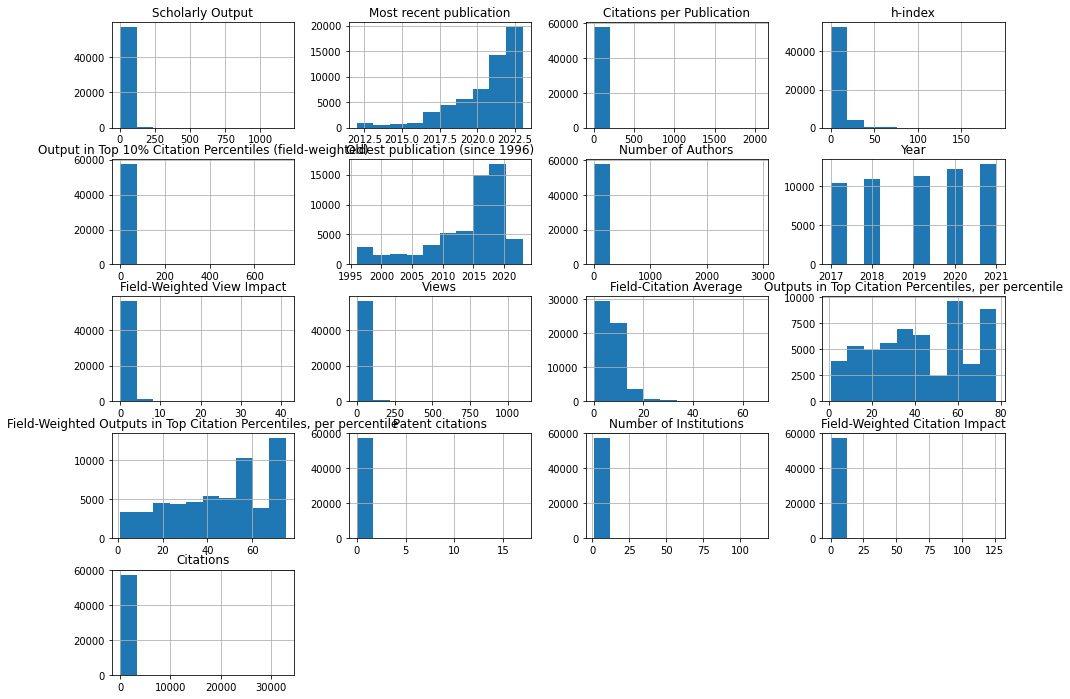

In [16]:
#Visualización del data frame 
df.hist(figsize=(16,12))
plt.show()

In [17]:
#Proposito: predecir potenciales rising star 
#Se tomara de referencia a los autores que comenzaron a publicar desde el 2013, es decir con una antiguedad no mayor de 10 años. 
#El resto ya tuvieron la oportunidad de desenvolverse, se busca autores excepcionales actuales  

In [18]:
OldPub=df['Oldest publication (since 1996)']< 2018
df['Old Publi']=OldPub
df=df.drop(df[df['Old Publi']==True].index)
df.shape

(20908, 57)

In [19]:
#Los rising star deben estar arriba del promedio, por lo cual se descartara los que no en Citations per Publication, 
print('Promedio (Citations per Publicatio):', df['Citations per Publication'].mean())
 

Promedio (Citations per Publicatio): 5.018533575664818


In [20]:
Citations_pub=df['Citations per Publication']< df['Citations per Publication'].mean()
df['Citations_pub']=Citations_pub
df=df.drop(df[df['Citations_pub']==True].index)
df.shape

(5964, 58)

In [21]:
print('Promedio (h-index)):', df['h-index'].mean())

Promedio (h-index)): 6.347417840375587


In [22]:
h_index=df['h-index']< df['h-index'].mean()
df['H_index']=h_index
df=df.drop(df[df['H_index']==True].index)
df.shape

(1884, 59)

<ipython-input-23-ec53634c3eac>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(['Topic Cluster number'],1).hist(figsize=(16,12))


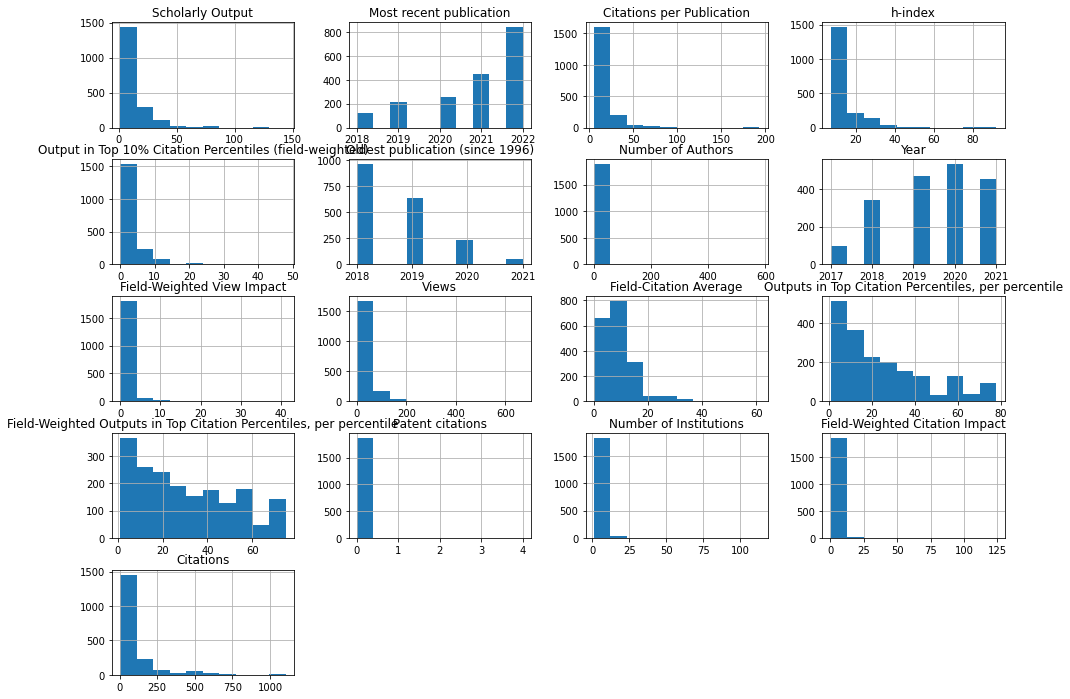

In [23]:
#Se quita la columna
df.drop(['Topic Cluster number'],1).hist(figsize=(16,12))
plt.show()

In [24]:
#Borrar columnas no útiles 
df.drop('Number of Authors',axis=1,inplace=True)
df.drop('Old Publi',axis=1,inplace=True)
df.drop('Citations_pub',axis=1,inplace=True)
df.drop('H_index',axis=1,inplace=True)
df.shape

(1884, 55)

In [25]:
#Borramos duplicados
df.drop_duplicates()
df.shape

(1884, 55)

In [26]:
#Imprimimos head con todas las columans
pd.set_option('display.max_rows',None)
df.head()

,Scopus author ID,Scholarly Output,Most recent publication,Citations per Publication,h-index,Output in Top 10% Citation Percentiles (field-weighted),Oldest publication (since 1996),Year,Full date,Scopus Source title,...,Time Higher Education (THE) field name,Sustainable Development Goals (2022),Topic Cluster name,Topic Cluster number,Topic name,Topic number,Topic Cluster Prominence Percentile,Topic Prominence Percentile,Field-Weighted Citation Impact,Citations
79,6504214415,4,2021,16.0,11,0,2019,2021,2021-12-01,BMC Infectious Diseases,...,"Clinical, pre-clinical and health",SDG 3,"Dengue,Viruses,Dengue Virus",170,"Chikungunya Fever,Togaviridae,Animals",3385,91.572,97.299,0.380,32.0
241,6505683507,1,2018,22.0,8,0,2018,2020,2020-12-01,Pharmacogenomics Journal,...,"Life Sciences| Clinical, pre-clinical and health",-,"Bilirubin,Carbon Monoxide,Heme Oxygenase-1",781,"Glucuronosyltransferase,Uridine Diphosphate Gl...",3832,52.441,88.524,0.880,12.0
439,6506293939,1,2019,34.0,12,1,2019,2019,2019-01-01,Contaduria y Administracion,...,Business and Economics,SDG 7| SDG 8| SDG 9| SDG 12,"Electricity,Energy,Economics",81,"Industrial Symbiosis,Sustainable Development,C...",8243,99.465,99.879,4.680,34.0
486,6506522157,1,2020,12.0,12,0,2020,2017,2017-05-01,Journal of Cellular Physiology,...,Life Sciences,SDG 3,"Brain-Derived Neurotrophic Factor,Neurogenesis...",161,"Nerve Protein,Reelin Receptor,Lissencephaly",8616,86.756,87.616,1.210,13.5
517,6506628226,7,2022,22.0,15,2,2018,2019,2019-01-01,Science,...,-,-,"Genes,Gene Regulatory Networks,Gene Expression",362,"Synthetic Biology,Escherichia Coli,Lyapunov-Kr...",5416,89.03,98.499,2.665,108.5


In [27]:
#Quitar columans no útiles 
df.drop('Most recent publication',axis=1,inplace=True)
df.drop('Oldest publication (since 1996)',axis=1,inplace=True)
df.drop('Year',axis=1,inplace=True)

In [28]:
#Buscar correlaciones entre columnas
df.corr()

,Scholarly Output,Citations per Publication,h-index,Output in Top 10% Citation Percentiles (field-weighted),Field-Weighted View Impact,Views,Field-Citation Average,"Outputs in Top Citation Percentiles, per percentile","Field-Weighted Outputs in Top Citation Percentiles, per percentile",Patent citations,Number of Institutions,Field-Weighted Citation Impact,Citations
Scholarly Output,1.000000,-0.056212,0.376102,0.854927,-0.070365,-0.020184,0.002381,-0.003068,-0.024671,-0.024230,-0.053330,-0.011603,0.720747
Citations per Publication,-0.056212,1.000000,0.279001,0.165661,0.064983,0.104686,0.111873,-0.205819,-0.211284,0.114144,0.045583,0.406203,0.396275
h-index,0.376102,0.279001,1.000000,0.490688,0.096722,0.033594,0.045304,-0.032264,-0.084865,0.095997,0.226945,0.233236,0.521540
Output in Top 10% Citation Percentiles (field-weighted),0.854927,0.165661,0.490688,1.000000,-0.014294,0.022436,0.003847,-0.089227,-0.140200,0.011563,-0.028945,0.125516,0.847158
Field-Weighted View Impact,-0.070365,0.064983,0.096722,-0.014294,1.000000,0.739305,-0.049377,-0.211861,-0.274919,0.041693,0.142282,0.542604,0.003480
Views,-0.020184,0.104686,0.033594,0.022436,0.739305,1.000000,0.276158,-0.306933,-0.273879,0.078781,0.034900,0.210805,0.056587
Field-Citation Average,0.002381,0.111873,0.045304,0.003847,-0.049377,0.276158,1.000000,-0.297130,-0.003776,0.160995,0.005917,-0.051484,0.108488
"Outputs in Top Citation Percentiles, per percentile",-0.003068,-0.205819,-0.032264,-0.089227,-0.211861,-0.306933,-0.297130,1.000000,0.878719,-0.061339,-0.078005,-0.279610,-0.151089
"Field-Weighted Outputs in Top Citation Percentiles, per percentile",-0.024671,-0.211284,-0.084865,-0.140200,-0.274919,-0.273879,-0.003776,0.878719,1.000000,-0.024924,-0.068074,-0.343531,-0.174497
Patent citations,-0.024230,0.114144,0.095997,0.011563,0.041693,0.078781,0.160995,-0.061339,-0.024924,1.000000,0.030210,0.078623,0.067809


In [29]:
#División entre varibles categóricas y numéricas
target = 'Field-Weighted Citation Impact'

categ_cols = [cname for cname in df.columns if df[cname].dtype == "object"]
numeric_cols = [cname for cname in df.columns if df[cname].dtype in ['int64', 'float64', 'uint8','int8']]

In [30]:
df_num = df[numeric_cols]
df_num.head()

,Scholarly Output,Citations per Publication,h-index,Output in Top 10% Citation Percentiles (field-weighted),Field-Weighted View Impact,Views,Field-Citation Average,"Outputs in Top Citation Percentiles, per percentile","Field-Weighted Outputs in Top Citation Percentiles, per percentile",Patent citations,Number of Institutions,Field-Weighted Citation Impact,Citations
79,4,16.0,11,0,1.15,13,3.80,55,55,0,2,0.380,32.0
241,1,22.0,8,0,0.65,11,7.46,47,58,0,4,0.880,12.0
439,1,34.0,12,1,8.54,395,7.27,5,4,0,2,4.680,34.0
486,1,12.0,12,0,1.10,27,9.71,23,38,0,3,1.210,13.5
517,7,22.0,15,2,1.09,31,16.88,2,5,0,6,2.665,108.5


In [31]:
X = df_num.drop(target,axis=1)
X.head()

,Scholarly Output,Citations per Publication,h-index,Output in Top 10% Citation Percentiles (field-weighted),Field-Weighted View Impact,Views,Field-Citation Average,"Outputs in Top Citation Percentiles, per percentile","Field-Weighted Outputs in Top Citation Percentiles, per percentile",Patent citations,Number of Institutions,Citations
79,4,16.0,11,0,1.15,13,3.80,55,55,0,2,32.0
241,1,22.0,8,0,0.65,11,7.46,47,58,0,4,12.0
439,1,34.0,12,1,8.54,395,7.27,5,4,0,2,34.0
486,1,12.0,12,0,1.10,27,9.71,23,38,0,3,13.5
517,7,22.0,15,2,1.09,31,16.88,2,5,0,6,108.5


In [32]:
Y = df_num[target]
Y.head()

79     0.380
241    0.880
439    4.680
486    1.210
517    2.665
Name: Field-Weighted Citation Impact, dtype: float64

In [33]:
#Regresión lineal 
Xc = sm.add_constant(X) 
model = sm.OLS(Y, Xc) 
results = model.fit()
print(results.summary())
results.rsquared_adj

                                  OLS Regression Results                                  
Dep. Variable:     Field-Weighted Citation Impact   R-squared:                       0.585
Model:                                        OLS   Adj. R-squared:                  0.582
Method:                             Least Squares   F-statistic:                     219.6
Date:                            Wed, 15 Mar 2023   Prob (F-statistic):               0.00
Time:                                    17:46:55   Log-Likelihood:                -4313.2
No. Observations:                            1884   AIC:                             8652.
Df Residuals:                                1871   BIC:                             8724.
Df Model:                                      12                                         
Covariance Type:                        nonrobust                                         
                                                                         coef    std err  

0.5821021686613828

In [34]:
#Separamos nuestra data dos partes para entrenar y para hacer el test.
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=.30,random_state=0)
print('Observaciones para el training:',X_train.shape[0],'Observaciones para el test:',X_test.shape[0])

Observaciones para el training: 1318 Observaciones para el test: 566


In [35]:
#Entrenamiento del módelo
model = LinearRegression()  
model.fit(X_train,y_train)  

LinearRegression()

In [36]:
predictions = model.predict(X_test)

print('Puntaje entrenamiento: {}\n'.format(model.score(X_train,y_train)))
print('Puntaje Test: {}\n'.format(model.score(X_test,y_test)))
print(model.intercept_, model.coef_) 
print('MAE',mean_absolute_error(y_test, predictions)) #mean absolute error
print('MSE',mean_squared_error(y_test, predictions))  #mean squared error

Puntaje entrenamiento: 0.6401702838137537

Puntaje Test: 0.09203997508828055

-0.15937906409321423 [ 0.01076471  0.08018445  0.02538535  0.05010534  2.18568903 -0.06299838
  0.07375306 -0.01271583 -0.01937132  0.11417873 -0.11213848 -0.00240506]
MAE 1.2423006977258655
MSE 4.873750446494127


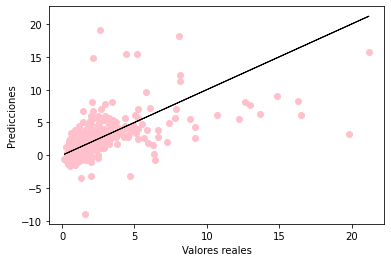

In [37]:
plt.scatter(y_test, predictions, color='pink')
plt.plot(y_test, y_test, linewidth=1, color='black')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.show()


In [38]:
#Regresión lineal con KNN
scaler = StandardScaler()
transformed_X=scaler.fit_transform(X)

X_train,X_test,y_train,y_test = train_test_split(transformed_X,Y,test_size=.30,random_state=0)

model = KNeighborsRegressor(5,metric='euclidean')  
model.fit(X_train,y_train)  
predictions = model.predict(X_test)


print('Puntaje entrenamiento: {}\n'.format(model.score(X_train,y_train)))
print('Puntaje Test: {}\n'.format(model.score(X_test,y_test)))
print('MAE',mean_absolute_error(y_test, predictions)) #mean absolute error
print('MSE',mean_squared_error(y_test, predictions))  #mean squared error

Puntaje entrenamiento: 0.5322903436682622

Puntaje Test: 0.5753259663860543

MAE 0.591452296819788
MSE 2.2795665053003535


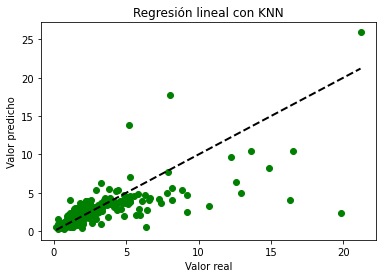

In [39]:
# Predicción con el modelo entrenado
predictions = model.predict(X_test)

# Crear una gráfica de dispersión
plt.scatter(y_test, predictions, color= 'green')

# Añadir una línea recta que represente la regresión lineal
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)

# Etiquetas para los ejes x e y y un título para la gráfica
plt.xlabel('Valor real')
plt.ylabel('Valor predicho')
plt.title('Regresión lineal con KNN')

# Mostrar la gráfica
plt.show()

In [40]:
#Regresión lineal con árbol de decisiones
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=.30,random_state=0)

model = DecisionTreeRegressor(max_depth=3)  
model.fit(X_train,y_train)  
predictions = model.predict(X_test)


print('Puntaje entrenamiento: {}\n'.format(model.score(X_train,y_train)))
print('Puntaje Test: {}\n'.format(model.score(X_test,y_test)))
print('MAE',mean_absolute_error(y_test, predictions)) #mean absolute error
print('MSE',mean_squared_error(y_test, predictions))  #mean squared error

Puntaje entrenamiento: 0.9045285275968588

Puntaje Test: 0.56581150979669

MAE 0.7716552244150312
MSE 2.330638232885576


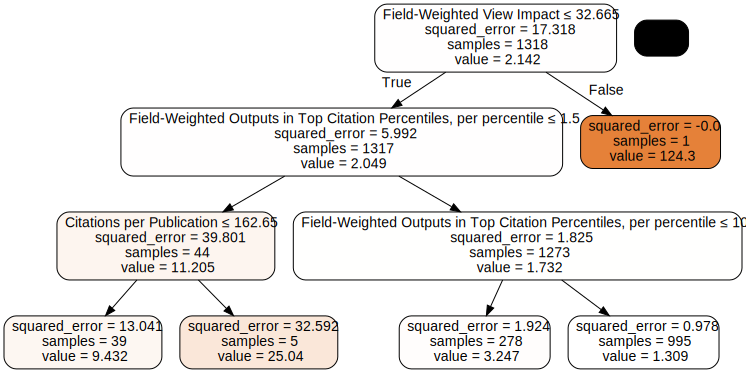

In [41]:
import graphviz
from sklearn.tree import export_graphviz
import pydotplus
# Exportar el árbol de decisiones
dot_data = export_graphviz(model, out_file=None, 
                           feature_names=X.columns.values,  
                           filled=True,rounded=True,  
                           special_characters=True)

# Crear la gráfica del árbol de decisiones
graph = pydotplus.graph_from_dot_data(dot_data)  

# Mostrar la gráfica
graphviz.Source(graph.to_string())


In [42]:
df.shape

(1884, 52)

In [43]:
fwvi=df['Field-Weighted View Impact']<= 32.665
df['fwi']=fwvi
df=df.drop(df[df['fwi']==False].index)
df.shape

(1883, 53)

In [44]:
OTCP=df['Outputs in Top Citation Percentiles, per percentile']<= 1.5
df['OTCP']=OTCP
df=df.drop(df[df['OTCP']==False].index)
df.shape

(79, 54)

In [45]:
CPP=df['Citations per Publication']<= 162.65
df['CPP']=CPP
df=df.drop(df[df['CPP']==True].index)
df.shape

(5, 55)

In [46]:
df.shape

(5, 55)

In [47]:
df.head()

,Scopus author ID,Scholarly Output,Citations per Publication,h-index,Output in Top 10% Citation Percentiles (field-weighted),Full date,Scopus Source title,Volume,Issue,Pages,...,Topic Cluster number,Topic name,Topic number,Topic Cluster Prominence Percentile,Topic Prominence Percentile,Field-Weighted Citation Impact,Citations,fwi,OTCP,CPP
17512,55316592700,1,178.0,48,1,2017-01-01,ACL 2017 - 55th Annual Meeting of the Associat...,1,-,873-883,...,37,"Word Processing,Lexical Cohesion,Segmentation",26836,98.06,69.871,26.890,237.5,True,True,False
17515,55316592700,1,178.0,48,1,2019-01-01,IEEE Access,7,-,100943-100953,...,37,"Sentiment Classification,Data Mining,Product R...",108,98.06,99.848,24.010,133.0,True,True,False
17516,55316592700,1,178.0,48,1,2020-01-01,ACL 2019 - 57th Annual Meeting of the Associat...,-,-,527-536,...,156,"Emotion Recognition,Emotional Speech,Emotion",1621,91.906,99.068,32.015,149.0,True,True,False
42624,57201522042,5,193.4,19,4,2018-01-01,Science,360,6384,67-70,...,8,"Perovskite Solar Cells,Solar Cell,Formamidine",20,99.866,99.996,14.840,689.5,True,True,False
42625,57201522042,5,193.4,19,4,2018-12-01,Nature Communications,9,1,-,...,8,"Perovskite Solar Cells,Solar Cell,Formamidine",20,99.866,99.996,8.055,538.0,True,True,False
